In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pos_fraction = np.linspace(0.00, 1.00, 1000)

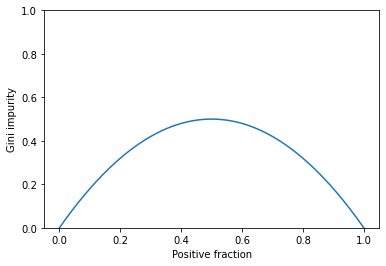

In [3]:
gini = 1 - pos_fraction**2 - (1 - pos_fraction)**2
plt.plot(pos_fraction, gini)
plt.ylim(0, 1)
plt.xlabel('Positive fraction')
plt.ylabel('Gini impurity')
plt.show()

In [4]:
def gini_impurity(labels):
    if not labels:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return 1 - np.sum(fractions**2)

In [5]:
print('{0:.4f}'.format(gini_impurity([1, 1, 0, 1, 0])))
print('{0:.4f}'.format(gini_impurity([1, 1, 0, 1, 0, 0])))
print('{0:.4f}'.format(gini_impurity([1, 1, 1, 1])))

0.4800
0.5000
0.0000


<ipython-input-11-6f1a3b3f2870>:2: RuntimeWarning: divide by zero encountered in log2
  ent = - (pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction))
<ipython-input-11-6f1a3b3f2870>:2: RuntimeWarning: invalid value encountered in multiply
  ent = - (pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction))


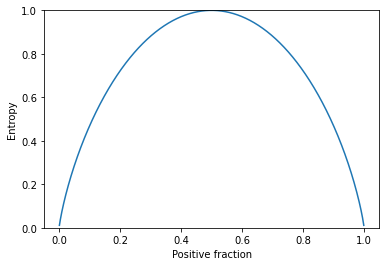

In [11]:
pos_fraction = np.linspace(0.00, 1.00, 1000)
ent = - (pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction))
plt.plot(pos_fraction, ent)
plt.xlabel('Positive fraction')
plt.ylabel('Entropy')
plt.ylim(0, 1)
plt.show()

In [12]:
def entropy(labels):
    if not labels:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return - np.sum(fractions * np.log2(fractions))

In [13]:
print('{0:.4f}'.format(entropy([1, 1, 0, 1, 0])))
print('{0:.4f}'.format(entropy([1, 1, 0, 1, 0, 0])))
print('{0:.4f}'.format(entropy([1, 1, 1, 1])))

0.9710
1.0000
-0.0000


In [16]:
criterion_function = {
    'gini': gini_impurity,
    'entropy': entropy
}

def weighted_impurity(groups, criterion='gini'):
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group) / float(total) * criterion_function[criterion](group)
    return weighted_sum

In [17]:
children_1 = [[1, 0, 1], [0, 1]]
children_2 = [[1, 1], [0, 0, 1]]
print('Entrypy of #1 split: {0:.4f}'.format(weighted_impurity(children_1, 'entropy')))
print('Entrypy of #2 split: {0:.4f}'.format(weighted_impurity(children_2, 'entropy')))

Entrypy of #1 split: 0.9510
Entrypy of #2 split: 0.5510


In [18]:
def gini_impurity_np(labels):
    if labels.size == 0:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return 1 - np.sum(fractions**2)

def entropy_np(labels):
    if labels.size == 0:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return - np.sum(fractions * np.log2(fractions))

In [19]:
criterion_function_np = {
    'gini': gini_impurity_np,
    'entropy': entropy_np
}

def weighted_impurity(groups, criterion='gini'):
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group) / float(total) * criterion_function_np[criterion](group)
    return weighted_sum

In [20]:
def split_node(X, y, index, value):
    x_index = X[:, index]
    if X[0, index].dtype.kind in ['i', 'f']:
        mask = x_index >= value
    else:
        mask = x_index == value
    left = [X[~mask, :], y[~mask]]
    right = [X[mask, :], y[mask]]
    return left, right

In [21]:
def get_best_split(X, y, criterion):
    best_index, best_value, best_score, children = None, None, 1, None
    for index in range(len(X[0])):
        for value in np.sort(np.unique(X[:, index])):
            groups = split_node(X, y, index, value)
            impurity = weighted_impurity([groups[0][1], groups[1][1]], criterion)
            if impurity < best_score:
                best_index, best_value, best_score, children = index, value, impurity, groups
    return {
        'index': best_index,
        'value': best_value,
        'children': children
    }

In [22]:
def get_leaf(labels):
    return np.bincount(labels).argmax()

In [23]:
def split(node, max_depth, min_size, depth, criterion):
    left, right = node['children']
    del (node['children'])
    
    # If one of the children is empty, this is a leaf node of the other child
    if left[1].size == 0:
        node['right'] = get_leaf(right[1])
        return
    if right[1].size == 0:
        node['left'] = get_leaf(left[1])
        return
    
    # Should not exceed max depth to prevent overfitting
    if depth >= max_depth:
        node['left'], node['right'] = get_leaf(left[1]), get_leaf(right[1])
        return
    
    # Should have enough samples to keep splitting, we only split left node
    if left[1].size <= min_size:
        node['left'] = get_leaf(left[1])
    else:
        result = get_best_split(left[0], left[1], criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['left'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['left'] = get_leaf(result_left[1])
        else:  # recurse
            node['left'] = result
            split(node['left'], max_depth, min_size, depth + 1, criterion)
    
    # Right child has enough samples?
    if right[1].size <= min_size:
        node['right'] = get_leaf(right[1])
    else:
        result = get_best_split(right[0], right[1], criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['right'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['right'] = get_leaf(result_left[1])
        else:
            node['right'] = result
            split(node['right'], max_depth, min_size, depth + 1, criterion)

In [24]:
def train_tree(X_train, y_train, max_depth, min_size, criterion='gini'):
    X = np.array(X_train)
    y = np.array(y_train)
    root = get_best_split(X, y, criterion)
    split(root, max_depth, min_size, 1, criterion)
    return root

In [25]:
X_train = [['tech', 'professional'],
           ['fashion', 'student'],
           ['fashion', 'professional'],
           ['sports', 'student'],
           ['tech', 'student'],
           ['tech', 'retired'],
           ['sports', 'professional']]
y_train = [1, 0, 0, 0, 1, 0, 1]
tree = train_tree(X_train, y_train, 2, 2)

In [26]:
CONDITION = {
    'numerical': {
        'yes': '>=',
        'no': '<'
    },
    'categorical': {
        'yes': 'is',
        'no': 'is not'
    }
}

def visualize_tree(node, depth=0):
    if isinstance(node, dict):
        if node['value'].dtype.kind in ['i', 'f']:
            condition = CONDITION['numerical']
        else:
            condition = CONDITION['categorical']
        print('{}|- X{} {} {}'.format(depth * '   ', node['index'] + 1, condition['no'], node['value']))
        if 'left' in node:
            visualize_tree(node['left'], depth + 1)
        print('{}|- X{} {} {}'.format(depth * '   ', node['index'] + 1, condition['yes'], node['value']))
        if 'right' in node:
            visualize_tree(node['right'], depth + 1)
    else:
        print('{}[{}]'.format(depth * '   ', node))

In [27]:
visualize_tree(tree)

|- X1 is not fashion
   |- X2 is not professional
      [0]
   |- X2 is professional
      [1]
|- X1 is fashion
   [0]


In [28]:
X_train_n = [[6, 7], [2, 4], [7, 2], [3, 6], [4, 7], [5, 2], [1, 6], [2, 0], [6, 3], [4, 1]]
y_train_n = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
tree = train_tree(X_train_n, y_train_n, 2, 2)
visualize_tree(tree)

|- X2 < 4
   |- X1 < 7
      [1]
   |- X1 >= 7
      [0]
|- X2 >= 4
   |- X1 < 2
      [1]
   |- X1 >= 2
      [0]


In [30]:
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_split=2)
tree_sk.fit(X_train_n, y_train_n)

DecisionTreeClassifier(max_depth=2)

In [32]:
import pandas as pd
n_rows = 300000
df = pd.read_csv('train.csv', nrows=n_rows)

In [33]:
print(df.head(5))

             id  click      hour    C1  banner_pos   site_id site_domain  \
0  1.000009e+18      0  14102100  1005           0  1fbe01fe    f3845767   
1  1.000017e+19      0  14102100  1005           0  1fbe01fe    f3845767   
2  1.000037e+19      0  14102100  1005           0  1fbe01fe    f3845767   
3  1.000064e+19      0  14102100  1005           0  1fbe01fe    f3845767   
4  1.000068e+19      0  14102100  1005           1  fe8cc448    9166c161   

  site_category    app_id app_domain  ... device_type device_conn_type    C14  \
0      28905ebd  ecad2386   7801e8d9  ...           1                2  15706   
1      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
2      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
3      28905ebd  ecad2386   7801e8d9  ...           1                0  15706   
4      0569f928  ecad2386   7801e8d9  ...           1                0  18993   

   C15  C16   C17  C18  C19     C20  C21  
0  320   50  

In [34]:
Y = df['click'].values

In [35]:
X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values
print(X.shape)

(300000, 19)


In [36]:
n_train = int(n_rows * 0.9)
X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]

In [37]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [38]:
X_train_enc = enc.fit_transform(X_train)
X_train_enc[0]

<1x8204 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [39]:
print(X_train_enc[0])

  (0, 2)	1.0
  (0, 6)	1.0
  (0, 188)	1.0
  (0, 2608)	1.0
  (0, 2679)	1.0
  (0, 3771)	1.0
  (0, 3885)	1.0
  (0, 3929)	1.0
  (0, 4879)	1.0
  (0, 7315)	1.0
  (0, 7319)	1.0
  (0, 7475)	1.0
  (0, 7824)	1.0
  (0, 7828)	1.0
  (0, 7869)	1.0
  (0, 7977)	1.0
  (0, 7982)	1.0
  (0, 8021)	1.0
  (0, 8189)	1.0


In [40]:
X_test_enc = enc.transform(X_test)

In [41]:
parameters = {'max_depth': [3, 10, None]}
from sklearn.model_selection import GridSearchCV

In [42]:
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30)

In [43]:
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

In [50]:
grid_search.fit(X_train_enc, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=30),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc')

In [51]:
print(grid_search.best_params_)

{'max_depth': 10}


In [54]:
decision_tree_best = grid_search.best_estimator_
pos_prob = decision_tree_best.predict_proba(X_test_enc)[:, 1]
from sklearn.metrics import roc_auc_score
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(Y_test, pos_prob)))

The ROC AUC on testing set is: 0.719


In [55]:
pos_prob = np.zeros(len(Y_test))
click_index = np.random.choice(len(Y_test), int(len(Y_test) * 51211.0/300000), replace=False)
pos_prob[click_index] = 1
roc_auc_score(Y_test, pos_prob)

0.5007831397812763

In [56]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)

In [58]:
grid_search = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train_enc, Y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(min_samples_split=30, n_jobs=-1),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc')

In [59]:
print(grid_search.best_params_)

{'max_depth': None}


In [60]:
random_forest_best = grid_search.best_estimator_

In [61]:
pos_prob = random_forest_best.predict_proba(X_test_enc)[:, 1]
print('the ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(Y_test, pos_prob)))

the ROC AUC on testing set is: 0.759
